In [4]:
%load_ext autoreload
%autoreload 2

import sys
import os
import logging

import numpy as np
import argparse
import copy
import pandas as pd
import shutil
import json
import urllib

from   datetime import datetime, timedelta

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.exc import InvalidRequestError, IntegrityError 
from sqlalchemy.orm.exc import NoResultFound

from matplotlib import pyplot as plt

from tradingdb.utils import *
from tradingdb.ORM.utils import *

logger = logging.getLogger()
logger.setLevel(logging.INFO)
# create file handler which logs even debug messages
handler = logging.StreamHandler()
handler.setLevel(logging.NOTSET)
format = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
handler.setFormatter(format)


logger.addHandler(handler)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# get all the FTSE symbols

In [5]:
symbols=download_ftse_symbols('FTSE-100')

In [6]:
len(symbols)

100

In [7]:
symbols.head()

,description,tidm,currency,issuercode,issuername,marketcapitalization,netchangesign,netchange,percentualchange,lastprice
0,JD SPORTS FASHION PLC ORD 0.05P,JD.,GBX,JODF,JD SPORTS FASHION PLC,6352244170,+1,3.0,2.436054,126.15
1,COCA-COLA HBC AG ORD CHF6.70 (CDI),CCH,GBX,COCCH,COCA-COLA HBC AG,7075464363,+1,43.5,2.254470,1973.00
2,FRESNILLO PLC ORD USD0.50,FRES,GBX,FRFRES,FRESNILLO PLC,6524455837,+1,16.4,1.852270,901.80
3,SCOTTISH MORTGAGE INV TST PLC ORD 5P,SMT,GBX,SCLQ,SCOTTISH MORTGAGE INVESTMENT TRUST PLC,10161798080,+1,7.0,0.977927,722.80
4,NEXT PLC ORD 10P,NXT,GBX,NEQT,NEXT PLC,7435228410,+1,54.0,0.938804,5806.00


In [8]:
handler.setLevel(logging.DEBUG)
DBNAME=os.path.abspath("../data/master.db")
if os.path.isfile(DBNAME):
    os.remove(DBNAME)
initialize_db(DBNAME,overwrite=True)

def create_all_FTSE100(symbols):

    fh=open("wrong_ftse100_stocks.json","w")
    session=get_new_session(DBNAME)
    with session.begin() as mysession:
        eid=mysession.query(stock.Exchange.id).filter(stock.Exchange.name=="FTSE").one()[0]
        cid=mysession.query(stock.Currency.id).filter(stock.Currency.name=="GBP").one()[0]
        

        for i,st in enumerate(symbols):
            #if i>10: break
            print(i,st)
            
            # get company name from yfinance
            if st[-1]==".":
                symbol=st[:-1]+".L"
            else:   
                symbol=st+".L"
            
            isthere=mysession.query(stock.Stock).filter(stock.Stock.symbol==st).all()
            
            if len(isthere)==0:
                print("Query  YF for symbol",symbol)
                ticker=yf.Ticker(symbol)

                info=ticker.info
                if info is None: continue
                if 'longName' in info.keys():
                    name=info['longName']
                elif 'shortName' in info.keys():
                    name=info['shortName']
                else:
                    name=st
                if 'exchange' not in info.keys():
                    print("Missing exchange name")
                    print(ticker)
                    json.dump(info, fh)
                    continue

                exchange=info['exchange']
                if exchange != "LSE":
                    print("Exchanche for %s is %s . Shouldn't it be LSE?"%(ticker,exchange))
                    json.dump(info, fh)
                    continue

                if 'currency' in info.keys():
                    
                    currency=info['currency'].upper()

                    if currency != 'GBP':
                        print("Currency for %s is %s"%(ticker,currency))
                        print("not sure what to do... skipping")
                        
                    else:
                        newstock=stock.Stock(company=name,symbol=st,yf_symbol=symbol,
                                exchange_id=eid,currency_id=cid)    
                        mysession.add(newstock)
                        print("...added!!!")

                else:
                    print("Missing currency!")
                    json.dump(info, fh)
                    continue
            else:
                print("The symbol is already there")

    fh.close()          

create_all_FTSE100(symbols['tidm'].values)



0 JD.
Query  YF for symbol JD.L
...added!!!
1 CCH
Query  YF for symbol CCH.L
...added!!!
2 FRES
Query  YF for symbol FRES.L
...added!!!
3 SMT
Query  YF for symbol SMT.L
...added!!!
4 NXT
Query  YF for symbol NXT.L
...added!!!
5 RR.
Query  YF for symbol RR.L
...added!!!
6 ADM
Query  YF for symbol ADM.L
...added!!!
7 MRO
Query  YF for symbol MRO.L
...added!!!
8 SN.
Query  YF for symbol SN.L
...added!!!
9 III
Query  YF for symbol III.L
...added!!!
10 BEZ
Query  YF for symbol BEZ.L
...added!!!
11 RKT
Query  YF for symbol RKT.L
...added!!!
12 HLN
Query  YF for symbol HLN.L
...added!!!
13 FCIT
Query  YF for symbol FCIT.L
...added!!!
14 CNA
Query  YF for symbol CNA.L
...added!!!
15 PSH
Query  YF for symbol PSH.L
...added!!!
16 INF
Query  YF for symbol INF.L
...added!!!
17 HSV
Query  YF for symbol HSV.L
...added!!!
18 TSCO
Query  YF for symbol TSCO.L
...added!!!
19 WPP
Query  YF for symbol WPP.L
...added!!!
20 SMDS
Query  YF for symbol SMDS.L
...added!!!
21 CRH
Query  YF for symbol CRH.L
...ad

# add yfinance information to the database

In [10]:
# sample few yfinance and get the headers to create an appropriate table
DBNAME=os.path.abspath("../data/master.db")

session=get_new_session(DBNAME)
ys=[]
with session.begin() as mysession:
    res=mysession.query(stock.Stock).all()
    for i,r in enumerate(res):
        print(i,r.yf_symbol)
        ys.append(yf.Ticker(r.yf_symbol).info)


0 JD.L
1 CCH.L
2 FRES.L
3 SMT.L
4 NXT.L
5 RR.L
6 ADM.L
7 MRO.L
8 SN.L
9 III.L
10 BEZ.L
11 RKT.L
12 HLN.L
13 FCIT.L
14 CNA.L
15 PSH.L
16 INF.L
17 HSV.L
18 TSCO.L
19 WPP.L
20 SMDS.L
21 CRH.L
22 AVV.L
23 MNG.L
24 ABDN.L
25 IMB.L
26 BME.L
27 PSON.L
28 HL.L
29 ANTO.L
30 ULVR.L
31 GSK.L
32 DGE.L
33 IHG.L
34 BARC.L
35 AAL.L
36 PRU.L
37 HSBA.L
38 ENT.L
39 RIO.L
40 KGF.L
41 SBRY.L
42 ITRK.L
43 PHNX.L
44 UTG.L
45 BATS.L
46 BA.L
47 SGE.L
48 NG.L
49 CPG.L
50 BLND.L
51 SMIN.L
52 CTEC.L
53 SSE.L
54 AV.L
55 SKG.L
56 MNDI.L
57 EDV.L
58 SHEL.L
59 NWG.L
60 LAND.L
61 VOD.L
62 ABF.L
63 LSEG.L
64 GLEN.L
65 BRBY.L
66 FLTR.L
67 AZN.L
68 STAN.L
69 LGEN.L
70 BP.L
71 BNZL.L
72 REL.L
73 SGRO.L
74 SPX.L
75 WEIR.L
76 CRDA.L
77 STJ.L
78 WTB.L
79 FRAS.L
80 EXPN.L
81 UU.L
82 RS1.L
83 SVT.L
84 LLOY.L
85 BKG.L
86 IAG.L
87 AHT.L
88 AAF.L
89 RTO.L
90 DCC.L
91 TW.L
92 SDR.L
93 AUTO.L
94 HLMA.L
95 RMV.L
96 OCDO.L
97 PSN.L
98 BDEV.L


In [11]:
df=pd.DataFrame.from_dict(ys)
df.drop("companyOfficers",axis=1,inplace=True)
#df.head()
#pd.set_option('max_columns', None)
#pd.set_option('display.max_rows', None)
from sqlalchemy import create_engine
print(DBNAME)
engine = create_engine('sqlite:///'+DBNAME, echo=False)

with engine.begin() as connection:
    df.to_sql('yf_info', con=connection,if_exists='replace')



/Users/davidebranduardi/Projects/Finance/trading-toolbox/tradingdb/tradingdb/data/master.db


In [12]:
handler.setLevel(logging.DEBUG)
#DBNAME=os.path.abspath("../data/master.db")
session=get_new_session(DBNAME)
from datetime import datetime, timedelta

# retrieve all the LSE symbols
deltadays=14
# open/close in UTC 
#UK	8:00 am to 4:30 pm
#US	2:30 pm to 9:00 pm
time_end=datetime.today().replace(hour=4, minute=30, microsecond=0)
# covid crisis: start new era from ftse slump (23 march)
time_start = time_end - timedelta(days=deltadays)
time_start=time_start.replace(hour=8, minute=0, microsecond=0)
print(time_start,time_end)

def add_df_to_yfsymbol(session,symbol,df,interval):
    # get stock id
    with session.begin() as mysession:
            for index, row in df.iterrows():
                # convert name into time
                sid=mysession.query(stock.Stock.id).filter(stock.Stock.yf_symbol==symbol).one()[0]
                pid=mysession.query(stock.Period.id).filter(stock.Period.name==interval).one()[0]
                print(index)
                q=mysession.query(stock.Price)
                q=q.filter(stock.Price.stock_id==sid)
                q=q.filter(stock.Price.period_id==pid)
                r=q.filter(stock.Price.date==index.to_pydatetime()).one_or_none()
                if r is None:
                    p=stock.Price(
                                stock_id=sid,
                                period_id=pid,
                                date=index.to_pydatetime(),  
                                open=row['Open'],
                                low=row['Low'],
                                high=row['High'],
                                close=row['Close'],
                                adjusted_close=row['Adj Close'],
                                volume=row['Volume'])
                    mysession.add(p)

#[1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]          
intervals=['1d','1h']

with session.begin() as mysession:
    q=mysession.query(stock.Stock).join(stock.Exchange).filter(stock.Exchange.name=="FTSE").all()
    symbols=[ r.yf_symbol for r in q ]
    #symbols=symbols[:5]
    print(symbols)
    for interval in intervals:
        dfd=download_data_from_yfsymbols(symbols,time_start,time_end,interval=interval)
        for k,v in dfd.items():
            print(k)# ,v.head())
            add_df_to_yfsymbol(session,k,v,interval)
            #break
        

2022-12-18 08:00:22 2023-01-01 04:30:22
['JD.L', 'CCH.L', 'FRES.L', 'SMT.L', 'NXT.L', 'RR.L', 'ADM.L', 'MRO.L', 'SN.L', 'III.L', 'BEZ.L', 'RKT.L', 'HLN.L', 'FCIT.L', 'CNA.L', 'PSH.L', 'INF.L', 'HSV.L', 'TSCO.L', 'WPP.L', 'SMDS.L', 'CRH.L', 'AVV.L', 'MNG.L', 'ABDN.L', 'IMB.L', 'BME.L', 'PSON.L', 'HL.L', 'ANTO.L', 'ULVR.L', 'GSK.L', 'DGE.L', 'IHG.L', 'BARC.L', 'AAL.L', 'PRU.L', 'HSBA.L', 'ENT.L', 'RIO.L', 'KGF.L', 'SBRY.L', 'ITRK.L', 'PHNX.L', 'UTG.L', 'BATS.L', 'BA.L', 'SGE.L', 'NG.L', 'CPG.L', 'BLND.L', 'SMIN.L', 'CTEC.L', 'SSE.L', 'AV.L', 'SKG.L', 'MNDI.L', 'EDV.L', 'SHEL.L', 'NWG.L', 'LAND.L', 'VOD.L', 'ABF.L', 'LSEG.L', 'GLEN.L', 'BRBY.L', 'FLTR.L', 'AZN.L', 'STAN.L', 'LGEN.L', 'BP.L', 'BNZL.L', 'REL.L', 'SGRO.L', 'SPX.L', 'WEIR.L', 'CRDA.L', 'STJ.L', 'WTB.L', 'FRAS.L', 'EXPN.L', 'UU.L', 'RS1.L', 'SVT.L', 'LLOY.L', 'BKG.L', 'IAG.L', 'AHT.L', 'AAF.L', 'RTO.L', 'DCC.L', 'TW.L', 'SDR.L', 'AUTO.L', 'HLMA.L', 'RMV.L', 'OCDO.L', 'PSN.L', 'BDEV.L']
[*********************100%***************

In [13]:
# now try doing a plot
import mplfinance as fplt

print("MPLFinance Version : {}".format(fplt.__version__))

DBNAME=os.path.abspath("../data/master.db")
session=get_new_session(DBNAME)

with session.begin() as mysession:
    # get the period and the stock so you can filkter
    q=mysession.query(stock.Price).join(stock.Stock).join(stock.Period)
    q=q.filter(stock.Period.name=='1h')
    q=q.filter(stock.Stock.yf_symbol=='BA.L')
    r=q.all()
    d=[{'date':row.date,'Open':row.open,'Close':row.close,'High':row.high,'Low':row.low,'Volume':row.volume} for row in r]
df=pd.DataFrame.from_dict(d)

MPLFinance Version : 0.12.9b7


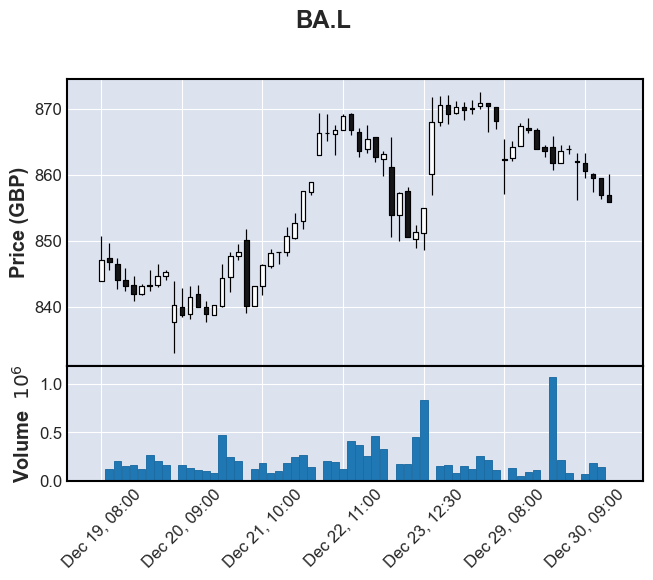

In [14]:
df['Datetime'] = pd.to_datetime(df['date'])
df = df.set_index('Datetime')

fplt.plot(
            df,
            type='candle',
            title='BA.L',
            ylabel='Price (GBP)',
            volume=True
        )

In [15]:
import plotly

print("Plotly Version : {}".format(plotly.__version__))
import plotly.graph_objects as go

candlestick = go.Candlestick(
                            x=df.index,
                            open=df['Open'],
                            high=df['High'],
                            low=df['Low'],
                            close=df['Close']
                            )

fig = go.Figure(data=[candlestick])

fig.show()

Plotly Version : 5.11.0


In [16]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Create subplots and mention plot grid size
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
               vertical_spacing=0.03, subplot_titles=('OHLC', 'Volume'), 
               row_width=[0.2, 0.7])

# Plot OHLC on 1st row
fig.add_trace(go.Candlestick(x=df["date"], open=df["Open"], high=df["High"],
                low=df["Low"], close=df["Close"], name="OHLC"), 
                row=1, col=1
)

# Bar trace for volumes on 2nd row without legend
fig.add_trace(go.Bar(x=df['date'], y=df['Volume'], showlegend=False), row=2, col=1)
fig.update_xaxes(
    rangeslider_visible=True,
    rangebreaks=[
        # NOTE: Below values are bound (not single values), ie. hide x to y
        dict(bounds=["sat", "mon"]),  # hide weekends, eg. hide sat to before mon
        dict(bounds=[17, 8], pattern="hour"),  # hide hours outside of 9.30am-4pm
        # dict(values=["2019-12-25", "2020-12-24"])  # hide holidays (Christmas and New Year's, etc)
    ]
)
# Do not show OHLC's rangeslider plot 
fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

In [17]:
df

,date,Open,Close,High,Low,Volume
Datetime,,,,,,
2022-12-19 08:00:00,2022-12-19 08:00:00,844.000000,847.200012,850.799988,844.000000,0.0
2022-12-19 09:00:00,2022-12-19 09:00:00,847.400024,846.799988,849.799988,845.599976,131304.0
2022-12-19 10:00:00,2022-12-19 10:00:00,846.599976,844.099976,847.400024,842.799988,208855.0
2022-12-19 11:00:00,2022-12-19 11:00:00,844.200012,843.200012,845.922180,842.526001,159707.0
2022-12-19 12:00:00,2022-12-19 12:00:00,843.400024,842.000000,844.799988,841.000000,166994.0
...,...,...,...,...,...,...
2022-12-30 08:00:00,2022-12-30 08:00:00,862.200012,862.000000,863.400024,856.231995,0.0
2022-12-30 09:00:00,2022-12-30 09:00:00,861.799988,860.599976,863.400024,859.608887,78554.0
2022-12-30 10:00:00,2022-12-30 10:00:00,860.200012,859.547974,860.400024,857.400024,187113.0


In [18]:
# datetime: midnight
from datetime import timezone
dt=datetime.combine(datetime.today(), datetime.min.time())
# open/close in UTC 
#UK	8:00 am to 4:30 pm
#US	2:30 pm to 9:00 pm
new_period=datetime.today().replace(hour=18, minute=0)
print(new_period.tzinfo) # naive object
# what is UTC when BST is new_period
timezone.utc


None


datetime.timezone.utc

In [19]:
df.head()

,date,Open,Close,High,Low,Volume
Datetime,,,,,,
2022-12-19 08:00:00,2022-12-19 08:00:00,844.000000,847.200012,850.799988,844.000000,0.0
2022-12-19 09:00:00,2022-12-19 09:00:00,847.400024,846.799988,849.799988,845.599976,131304.0
2022-12-19 10:00:00,2022-12-19 10:00:00,846.599976,844.099976,847.400024,842.799988,208855.0
2022-12-19 11:00:00,2022-12-19 11:00:00,844.200012,843.200012,845.922180,842.526001,159707.0
2022-12-19 12:00:00,2022-12-19 12:00:00,843.400024,842.000000,844.799988,841.000000,166994.0


In [20]:
timezone.tzname#

<method 'tzname' of 'datetime.timezone' objects>

In [21]:
import yfinance as yf
from datetime import timezone